#Stop or not stop signal

We are going to build a Neural Network capable to recognize images of roads with a stop sign or not

#Import Libraries

Cloud and Os

In [44]:
pip install skillsnetwork

In [45]:
pip install ibm-cos-sdk

In [46]:
import uuid
import shutil
import json
import copy
import os
from datetime import datetime
from skillsnetwork import cvstudio

Data Processing and Visualization

In [47]:
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import math
from matplotlib.pyplot import imshow
from tqdm import tqdm
from ipywidgets import IntProgress
import time

Deep Learning

In [48]:
import torch
import torchvision.models as models
from torch.utils.data import Dataset, DataLoader,random_split
from torch.optim import lr_scheduler
from torchvision import transforms
import torch.nn as nn

In [49]:
torch.manual_seed(42) #set a seed for reproduce results

We are defining a function for plot train_cost and validation_accuracy

In [50]:
def plot_stuff(COST,ACC):
    fig, ax1 = plt.subplots()
    color = 'tab:red'
    ax1.plot(COST, color = color)
    ax1.set_xlabel('Iteration', color = color)
    ax1.set_ylabel('total loss', color = color)
    ax1.tick_params(axis = 'y', color = color)

    ax2 = ax1.twinx()
    color = 'tab:blue'
    ax2.set_ylabel('accuracy', color = color)  # we already handled the x-label with ax1
    ax2.plot(ACC, color = color)
    ax2.tick_params(axis = 'y', color = color)
    fig.tight_layout()  # otherwise the right y-label is slightly clipped

    plt.show()

Plot a transformed image

In [51]:
def show_images(file_paths, labels, num_images=3):
    fig, axes = plt.subplots(1, num_images, figsize=(15, 5))
    for i in range(num_images):
        img = Image.open(file_paths[i])
        axes[i].imshow(img)
        axes[i].set_title(f'Label: {labels[i]}')
        axes[i].axis('off')
    plt.show()

Compare predictions and actual value

In [52]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [53]:
def result(model,x,y):
    #x,y=sample
    z=model(x.unsqueeze_(0))
    _,yhat=torch.max(z.data, 1)

    if yhat.item()!=y:
        text="predicted: {} actual: {}".format(str(yhat.item()),y)
        print(text)

#Load Data

In [54]:
directory_not = '/content/drive/MyDrive/Stop_detection/not_stop'
directory_stop = '/content/drive/MyDrive/Stop_detection/stop'


not_files = [os.path.join(directory_not, file) for file in os.listdir(directory_not) if file.endswith(".jpg")]
stop_files = [os.path.join(directory_stop, file) for file in os.listdir(directory_stop) if file.endswith(".jpg")]

not_files = sorted(not_files)
stop_files = sorted(stop_files)


Now we have our images with a stop signal in a list and the anothers in other list, as we wanna create an image classifier we are going to set the following labels:

  - stop_signal = y_hat = 1
  - no_stop_signal = y_hat = 0

In [55]:
len_y_hat = len(stop_files)+len(not_files)

len_y_hat, len(stop_files), len(not_files)

(163, 77, 86)

In [56]:
all_files = [not_files[i//2] if i % 2 == 0 else stop_files[i//2] for i in range(2 * len(stop_files))]

print(all_files[:4])

['/content/drive/MyDrive/Stop_detection/not_stop/101.jpg', '/content/drive/MyDrive/Stop_detection/stop/1.jpg', '/content/drive/MyDrive/Stop_detection/not_stop/102.jpg', '/content/drive/MyDrive/Stop_detection/stop/10.jpg']


As we can see, ur peer labels are relationate with the images of roads with no stop signal

In [57]:
Y = torch.zeros([len(all_files)])
Y = Y.type(torch.LongTensor)

Y[::2]=0
Y[1::2]=1

Y[:4]


tensor([0, 1, 0, 1])

Split our dataset in training and validation dataset. 80% will be used for trainig

In [58]:
class Dataset(Dataset):
  def __init__(self, X, Y):
    self.X = X
    self.Y = Y

  def __len__(self):
    return len(self.X)

  def __getitem__(self, idx):
    x = self.X[idx]
    y = self.Y[idx]
    return x, y

In [59]:
dataset = Dataset(all_files, Y)

In [60]:
train_size = int(0.8*len(dataset))
val_size = len(dataset) - train_size

In [61]:
tr_dts, val_dts = random_split(dataset, [train_size, val_size])

In [62]:
tr_loader = DataLoader(tr_dts, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dts, batch_size=1, shuffle=False)

print(f'Size in the training dataset: {len(tr_dts)}')
print(f'Size in the validation dataset: {len(val_dts)}')

Size in the training dataset: 123
Size in the validation dataset: 31


Let's print some examples with the hipotetic labels

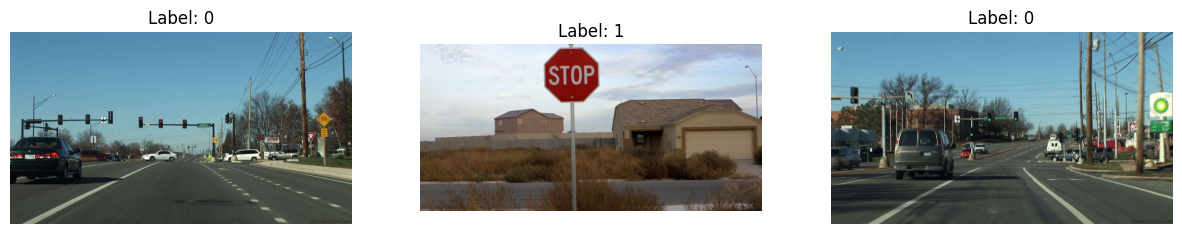

In [63]:
show_images(all_files, Y, num_images=3)

#Hyperparameters

In [64]:
n_epochs = 15

batch_size = 32

lr = 0.000001

momentum =0.5

lr_scheduler=True

base_lr = 0.001

max_lr = 0.01

#Load a pretrained model and train

In [78]:
import copy

Define our transformation resizing and converting to a PyTorch tensors

In [67]:
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])

composed = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(), transforms.RandomRotation(degrees=5),
    transforms.ToTensor(), transforms.Normalize(mean, std)])

In [85]:
def train_model(model, train_loader,validation_loader, criterion, optimizer, n_epochs, scheduler=None ,device='cpu',print_=True):
    loss_list = []
    accuracy_list = []
    accuracy_best=0
    best_model_wts = copy.deepcopy(model.state_dict())

    n_test = len(val_loader.dataset)
    n_train = len(tr_loader.dataset)

    print("The first epoch should take several minutes")

    for epoch in tqdm(range(n_epochs)):
        loss_sublist = []
        model.train()

        for batch in tr_loader:
            images_paths = batch[0]
            images =[composed(Image.open(image_path).convert("RGB")) for image_path in images_paths]
            x = torch.stack(images).to(device)
            y = batch[1].to(device)

            optimizer.zero_grad()

            z = model(x)
            loss = criterion(z, y)
            loss.backward()
            optimizer.step()

            loss_sublist.append(loss.data.item())

        print("epoch {} done".format(epoch) )

        loss_list.append(np.mean(loss_sublist))
        correct = 0

        model.eval()

        with torch.no_grad():
          for batch in val_loader:

            images_paths = batch[0]
            images =[composed(Image.open(image_path).convert("RGB")) for image_path in images_paths]
            x_test = torch.stack(images).to(device)
            y_test = batch[1].to(device)

            z = model(x_test)
            _, yhat = torch.max(z.data, 1)
            correct += (yhat == y_test).sum().item()

        accuracy = correct / n_test
        accuracy_list.append(accuracy)

        if accuracy>accuracy_best:
            accuracy_best=accuracy
            best_model_wts = copy.deepcopy(model.state_dict())


        if print_:
            print('learning rate',optimizer.param_groups[0]['lr'])
            print("The validaion  Cost for each epoch " + str(epoch + 1) + ": " + str(np.mean(loss_sublist)))
            print("The validation accuracy for epoch " + str(epoch + 1) + ": " + str(accuracy))

        if scheduler:
          scheduler.step()

    model.load_state_dict(best_model_wts)
    return accuracy_list,loss_list, model

In [66]:
import torchvision.models as models

model = models.resnet18(pretrained=True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [68]:
for param in model.parameters():
  param.requires_grad = False

In [69]:
model.fc = nn.Linear(512, 2)

In [70]:
model.to('cpu')

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [71]:
criterion = nn.CrossEntropyLoss()

In [72]:
optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=momentum)

In [73]:
if lr_scheduler:
    scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr=0.001, max_lr=0.01,step_size_up=5,mode="triangular2")

Now we are going to train our model :)

In [77]:
for batch in train_loader:
    print(type(batch), len(batch))  # Verifica el tipo y longitud de batch
    print([type(b) for b in batch])  # Imprime los tipos de cada elemento en batch
    break

<class 'list'> 2
[<class 'tuple'>, <class 'torch.Tensor'>]


In [86]:
start_datetime = datetime.now()
start_time=time.time()

accuracy_list,loss_list, model=train_model(model ,tr_loader , val_loader, criterion, optimizer, n_epochs=n_epochs)

end_datetime = datetime.now()
current_time = time.time()
elapsed_time = current_time - start_time
print("elapsed time", elapsed_time )

The first epoch should take several minutes


  0%|          | 0/15 [00:00<?, ?it/s]

epoch 0 done


  7%|▋         | 1/15 [01:06<15:24, 66.05s/it]

learning rate 0.001
The validaion  Cost for each epoch 1: 0.773863673210144
The validation accuracy for epoch 1: 0.5483870967741935
epoch 1 done


 13%|█▎        | 2/15 [01:28<08:42, 40.22s/it]

learning rate 0.001
The validaion  Cost for each epoch 2: 0.7189361751079559
The validation accuracy for epoch 2: 0.5806451612903226
epoch 2 done


 20%|██        | 3/15 [01:49<06:17, 31.45s/it]

learning rate 0.001
The validaion  Cost for each epoch 3: 0.6524503231048584
The validation accuracy for epoch 3: 0.8709677419354839
epoch 3 done


 27%|██▋       | 4/15 [02:10<05:03, 27.61s/it]

learning rate 0.001
The validaion  Cost for each epoch 4: 0.5472810491919518
The validation accuracy for epoch 4: 0.8709677419354839
epoch 4 done


 33%|███▎      | 5/15 [02:31<04:09, 24.91s/it]

learning rate 0.001
The validaion  Cost for each epoch 5: 0.5299586057662964
The validation accuracy for epoch 5: 0.8709677419354839
epoch 5 done


 40%|████      | 6/15 [02:52<03:34, 23.82s/it]

learning rate 0.001
The validaion  Cost for each epoch 6: 0.41884803026914597
The validation accuracy for epoch 6: 0.9354838709677419
epoch 6 done


 47%|████▋     | 7/15 [03:13<03:01, 22.71s/it]

learning rate 0.001
The validaion  Cost for each epoch 7: 0.39402008801698685
The validation accuracy for epoch 7: 0.8387096774193549
epoch 7 done


 53%|█████▎    | 8/15 [03:34<02:36, 22.41s/it]

learning rate 0.001
The validaion  Cost for each epoch 8: 0.3492390438914299
The validation accuracy for epoch 8: 0.9354838709677419
epoch 8 done


 60%|██████    | 9/15 [03:55<02:11, 21.85s/it]

learning rate 0.001
The validaion  Cost for each epoch 9: 0.3333241492509842
The validation accuracy for epoch 9: 0.9032258064516129
epoch 9 done


 67%|██████▋   | 10/15 [04:17<01:49, 21.87s/it]

learning rate 0.001
The validaion  Cost for each epoch 10: 0.31294573098421097
The validation accuracy for epoch 10: 0.8387096774193549
epoch 10 done


 73%|███████▎  | 11/15 [04:37<01:25, 21.41s/it]

learning rate 0.001
The validaion  Cost for each epoch 11: 0.33000360429286957
The validation accuracy for epoch 11: 0.8709677419354839
epoch 11 done


 80%|████████  | 12/15 [04:59<01:04, 21.61s/it]

learning rate 0.001
The validaion  Cost for each epoch 12: 0.3029637783765793
The validation accuracy for epoch 12: 0.9354838709677419
epoch 12 done


 87%|████████▋ | 13/15 [05:20<00:42, 21.35s/it]

learning rate 0.001
The validaion  Cost for each epoch 13: 0.28515245020389557
The validation accuracy for epoch 13: 0.8709677419354839
epoch 13 done


 93%|█████████▎| 14/15 [05:42<00:21, 21.49s/it]

learning rate 0.001
The validaion  Cost for each epoch 14: 0.2514997087419033
The validation accuracy for epoch 14: 0.8709677419354839
epoch 14 done


100%|██████████| 15/15 [06:03<00:00, 24.22s/it]

learning rate 0.001
The validaion  Cost for each epoch 15: 0.27263062074780464
The validation accuracy for epoch 15: 0.8709677419354839
elapsed time 363.30917477607727


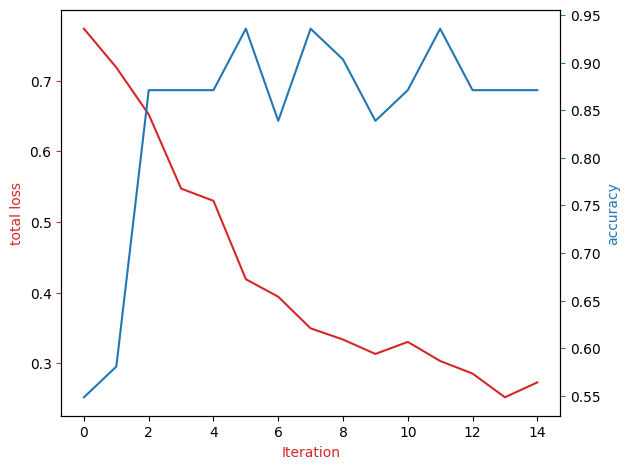

In [87]:
plot_stuff(loss_list,accuracy_list)